In [1]:

from __future__ import annotations

import argparse
from dataclasses import dataclass
from pathlib import Path
from typing import List, Sequence

import numpy as np
import pandas as pd
import torch
import sys
sys.path.append("../../CausalPFN")
from src.causalpfn import CATEEstimator
# from causalpfn import CATEEstimator
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt



/opt/anaconda3/envs/csc/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

REPO_ROOT = Path("./").absolute()
DATA_DIR = REPO_ROOT / "data" / "cdcsvi_nohsdp_poverty_disc"
DEFAULT_CSV = DATA_DIR / "full_dataset.csv"
DEFAULT_FEATURE_DIR = DATA_DIR / "features_dinov3_vitl16_large"
PLOT_DIR = REPO_ROOT / "downloads" / "training_curves"
DROP_ORDER_INFO = [
    ("EP_NOINT", 0.10835388560054054, "no internet"),
    ("EP_DISABL", 0.052309518971272125, "disabled residents"),
    ("EP_AGE65", 0.03462559284916882, "age 65+"),
    ("EP_NOVEH", 0.03215625814964905, "no vehicle"),
    ("EP_LIMENG", 0.02169817521202527, "limited English proficiency"),
    ("EP_AGE17", 0.019733735688725287, "age 17 or younger"),
    ("EP_UNEMP", 0.01749401722098651, "unemployment"),
    ("RPL_THEME3", 0.01628507092659359, "SVI Theme 3 percentile"),
    ("EP_SNGPNT", 0.016162292726655373, "single-parent households"),
    ("EP_MUNIT", 0.013712076635576134, "multi-unit housing"),
    ("EP_MINRTY", 0.006506325206589632, "minority (non-white)"),
]
DROP_ORDER = [name for name, _, _ in DROP_ORDER_INFO]
DROP_DESCRIPTIONS = {name: desc for name, _, desc in DROP_ORDER_INFO}


In [3]:
class Args:
    def __init__(self):
        self.csv_path = DEFAULT_CSV
        self.feature_dir = DEFAULT_FEATURE_DIR
        self.val_fraction = 0.2
        self.random_state = 42
        self.embedding_dim = 32
        self.pca = False
        self.joint_embedding = True
        self.embedding_epochs = 300
        self.embedding_lr = 0.0001
        self.cate_max_steps = None
        self.standardize = False

args = Args()

In [4]:
from linear_fit import *

data loading and preprocess

In [5]:
df = load_tabular_data(args.csv_path)
true_cate = load_true_cate(args.csv_path)
if true_cate is not None and len(true_cate) != len(df):
    print(
        f"Warning: cate.txt contains {len(true_cate)} rows but dataset has {len(df)}; "
        "skipping PEHE computation."
    )
    true_cate = None
elif true_cate is None:
    print(
        f"Warning: cate.txt not found in {args.csv_path.parent}; "
        "skipping PEHE computation."
    )
else:
    print("TRUE CATE:", true_cate.mean(), true_cate.std())

ordered_covs = [c for c in DROP_ORDER if c in df.columns]
other_covs = [
    c
    for c in df.columns
    if c not in {"row_id", "treatment", "outcome"} and c not in ordered_covs
]
covariates = ordered_covs + other_covs
print(f"Loaded {len(df)} rows with {len(covariates)} covariates.")

row_ids = df["row_id"].astype(int).tolist()
features = load_feature_matrix(args.feature_dir, row_ids)
print(f"Feature matrix shape: {features.shape}")

indices = np.arange(len(df))
train_idx, val_idx = train_test_split(
    indices,
    test_size=args.val_fraction,
    random_state=args.random_state,
    shuffle=True,
    stratify=df["treatment"]
)

if args.standardize:
    print("standardize feature")
    train_features = features[train_idx]
    scaler = StandardScaler()
    scaler.fit(train_features)
    features = scaler.transform(features)

scaler = StandardScaler()
scaler.fit(df.loc[train_idx, covariates].to_numpy(dtype=float))
df.loc[:, covariates] = scaler.transform(df[covariates].to_numpy(dtype=float))

y = df["outcome"].to_numpy(dtype=float)

treatment = df["treatment"].astype(float).to_numpy()

print(
    f"Train/val split: {len(train_idx)} train / {len(val_idx)} val "
    f"(val frac={args.val_fraction:.2f})"
)

TRUE CATE: 6.607962418614206 3.4835151356044105
Loaded 6693 rows with 11 covariates.
Feature matrix shape: (6693, 1024)
Train/val split: 5354 train / 1339 val (val frac=0.20)


## Experiment 1: Linear Regression (Covariates + Treatment -> Outcome)

In [6]:
model = LinearRegression()
X = df[covariates + ["treatment"]].to_numpy()
Y = df['outcome'].to_numpy()
model.fit(X[train_idx], Y[train_idx])
preds = model.predict(X[val_idx])

Text(0.5, 1.0, 'Linear Regression Result - All covariates (R^2=0.69)')

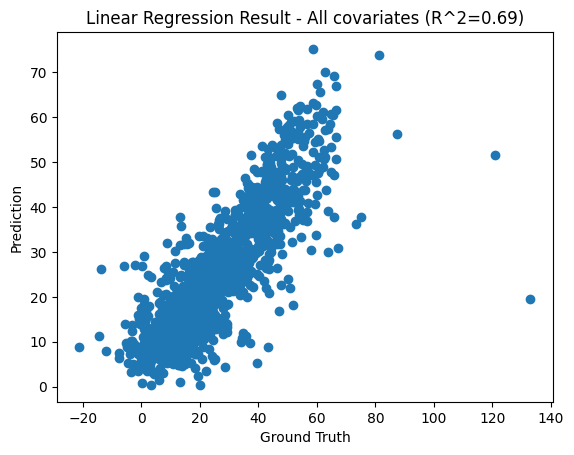

In [7]:
import matplotlib.pyplot as plt
plt.scatter(Y[val_idx], preds)

plt.xlabel("Ground Truth")
plt.ylabel("Prediction")
plt.title("Linear Regression Result - All covariates (R^2={:.2f})".format(r2_score(Y[val_idx], preds)))

experiment on all data 


Experiments (validation MAE | R^2):
[Covariate masking] baseline           -> MAE=6.5079 | R^2=0.6949 | remaining=11
[Covariate masking] drop EP_NOINT (no internet) -> MAE=6.9703 | R^2=0.6581 | remaining=10
[Covariate masking] drop EP_DISABL (disabled residents) -> MAE=7.1775 | R^2=0.6462 | remaining=9
[Covariate masking] drop EP_AGE65 (age 65+) -> MAE=7.2023 | R^2=0.6448 | remaining=8
[Covariate masking] drop EP_NOVEH (no vehicle) -> MAE=7.9923 | R^2=0.5785 | remaining=7
[Covariate masking] drop EP_LIMENG (limited English proficiency) -> MAE=8.1989 | R^2=0.5629 | remaining=6
[Covariate masking] drop EP_AGE17 (age 17 or younger) -> MAE=8.1935 | R^2=0.5636 | remaining=5
[Covariate masking] drop EP_UNEMP (unemployment) -> MAE=8.3036 | R^2=0.5526 | remaining=4
[Covariate masking] drop RPL_THEME3 (SVI Theme 3 percentile) -> MAE=8.4873 | R^2=0.5397 | remaining=3
[Covariate masking] drop EP_SNGPNT (single-parent households) -> MAE=8.8482 | R^2=0.5019 | remaining=2
[Covariate masking] drop E

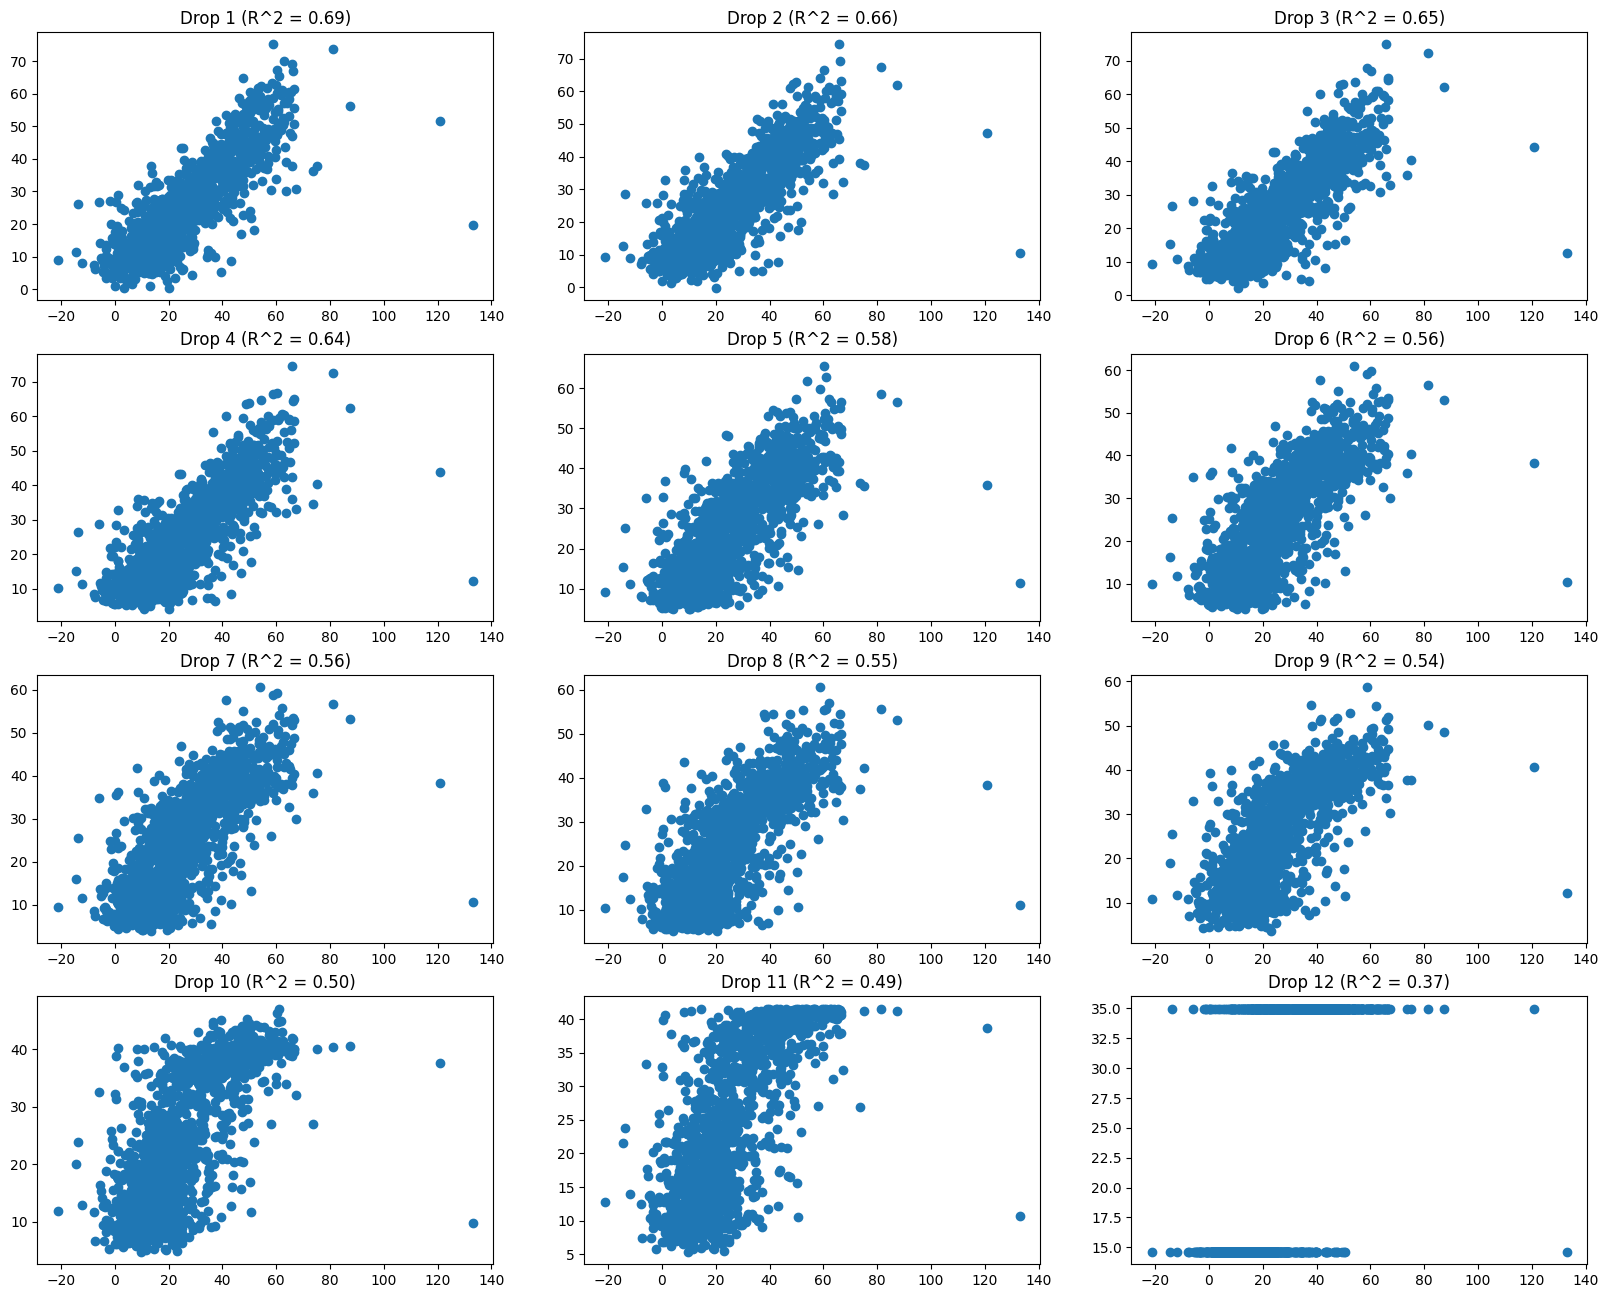

In [8]:
print("\nExperiments (validation MAE | R^2):")
cov_results = covariate_masking_experiments(
    df, covariates, train_idx, val_idx, drop_order=DROP_ORDER
)
n_cols = 3
n_rows = len(cov_results) // n_cols
fig, axes = plt.subplots(n_rows, n_cols)
fig.set_figheight(16)
fig.set_figwidth(20)
for i, res in enumerate(cov_results):
    print(
        f"[Covariate masking] {res.label:<18} -> "
        f"MAE={res.mae:.4f} | R^2={res.r2:.4f} | "
        f"remaining={len(res.remaining_covariates)}"
    )
    row = i // n_cols
    col = i % n_cols
    axes[row, col].scatter(df['outcome'][val_idx], res.preds)
    axes[row, col].set_title("Drop {} (R^2 = {:.2f})".format(i+1, res.r2))
    

## Experiment 2: CausalPFN (Covariates + Treatment -> Outcome)

In [9]:
from linear_fit import _predict_potential_outcomes
def fit_and_score_cate(
    X: np.ndarray,
    treatment: np.ndarray,
    outcome: np.ndarray,
    train_idx: np.ndarray,
    val_idx: np.ndarray,
    device: str = "cpu",
    calibration: bool = False
) -> tuple[float, float, np.ndarray]:
    estimator = CATEEstimator(device=device, calibrate=calibration)
    X_train = X[train_idx]
    t_train = treatment[train_idx]
    y_train = outcome[train_idx]
    estimator.fit(X_train, t_train, y_train)

    mu0, mu1 = _predict_potential_outcomes(estimator, X[val_idx])
    t_val = treatment[val_idx]
    y_val = outcome[val_idx]
    y_pred = np.where(t_val >= 0.5, mu1, mu0)
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    cate = mu1 - mu0

    mu0_t, mu1_t = _predict_potential_outcomes(estimator, X[train_idx])
    y_pred_train = np.where(t_train >= 0.5, mu1_t, mu0_t)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    r2_train = r2_score(y_train, y_pred_train)
    cate_train = mu1_t - mu0_t

    return y_pred, mae, r2, cate, (mae_train, r2_train, cate_train)

def fit_and_score_cate_2(
    X: np.ndarray,
    treatment: np.ndarray,
    outcome: np.ndarray,
    device: str = "cpu"
) -> tuple[float, float, np.ndarray]:
    """
    Use all data to predict
    """
    estimator = CATEEstimator(device=device)
    estimator.fit(X, treatment, outcome)

    mu0, mu1 = _predict_potential_outcomes(estimator, X)

    y_pred = np.where(treatment >= 0.5, mu1, mu0)
    mae = mean_absolute_error(outcome, y_pred)
    r2 = r2_score(outcome, y_pred)
    cate = mu1 - mu0

    return y_pred, mae, r2, cate, None

def run_cate_masking_experiments(
    df: pd.DataFrame,
    schedule: List[ExperimentResult],
    treatment: np.ndarray,
    outcome: np.ndarray,
    train_idx: np.ndarray,
    val_idx: np.ndarray,
    extra_features: np.ndarray | None,
    true_cate: np.ndarray | None,
    label_prefix: str,
    max_steps: int | None = None,
    standardize: bool = False,
    calibration: bool = False
) -> None:
    n_cols = 3
    n_rows = len(schedule) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols)
    fig.set_figheight(16)
    fig.set_figwidth(20)

    if standardize:
        outcome = outcome.reshape(-1, 1)
        scalar = StandardScaler()
        scalar.fit_transform(outcome)
        outcome = outcome.reshape(-1)
        
    for idx, res in enumerate(schedule):
        if max_steps is not None and idx >= max_steps:
            break
        if res.remaining_covariates:
            X_tabular = df[res.remaining_covariates].to_numpy(dtype=float)
        else:
            X_tabular = np.empty((len(df), 0), dtype=float)

        if extra_features is not None:
            X = np.concatenate([X_tabular, extra_features], axis=1)
        else:
            if X_tabular.shape[1] == 0:
                # Provide a constant feature so the estimator can still run.
                X = np.ones((len(df), 1), dtype=float)
            else:
                X = X_tabular
        X = X.astype(np.float32, copy=False)
        y_pred, mae, r2, cate, _ = fit_and_score_cate_2(X, treatment, outcome)
        if standardize:
            cate = cate * scalar.scale_
            
        metrics = (
            f"{label_prefix} {res.label:<18} -> MAE={mae:.4f} | R^2={r2:.4f} | "
            f"CATE mean={cate.mean():.4f} std={cate.std():.4f}"
        )
        # pehe = compute_pehe(cate, true_cate[val_idx])
        pehe = compute_pehe(cate, true_cate)
        metrics = f"{metrics} | PEHE={pehe:.4f}"
        
        print(
            metrics
        )

        row = idx // n_cols
        col = idx % n_cols
        axes[row, col].scatter(df['outcome'], y_pred)
        axes[row, col].set_title("Drop {} (R^2 = {:.2f})".format(i+1, r2))
    


[CATE covs] baseline           -> MAE=5.6407 | R^2=0.7587 | CATE mean=6.2100 std=3.8628 | PEHE=2.6349
[CATE covs] drop EP_NOINT (no internet) -> MAE=6.0048 | R^2=0.7324 | CATE mean=8.3600 std=4.1636 | PEHE=3.3824
[CATE covs] drop EP_DISABL (disabled residents) -> MAE=6.2722 | R^2=0.7158 | CATE mean=9.6726 std=3.8619 | PEHE=4.1863
[CATE covs] drop EP_AGE65 (age 65+) -> MAE=6.4787 | R^2=0.6998 | CATE mean=10.1620 std=3.7701 | PEHE=4.7115
[CATE covs] drop EP_NOVEH (no vehicle) -> MAE=7.1307 | R^2=0.6468 | CATE mean=13.4761 std=4.6603 | PEHE=7.8109
[CATE covs] drop EP_LIMENG (limited English proficiency) -> MAE=7.2669 | R^2=0.6355 | CATE mean=13.5535 std=4.5198 | PEHE=7.8094
[CATE covs] drop EP_AGE17 (age 17 or younger) -> MAE=7.3949 | R^2=0.6238 | CATE mean=13.4383 std=4.1488 | PEHE=7.6591
[CATE covs] drop EP_UNEMP (unemployment) -> MAE=7.5707 | R^2=0.6072 | CATE mean=13.9776 std=3.9089 | PEHE=8.0864
[CATE covs] drop RPL_THEME3 (SVI Theme 3 percentile) -> MAE=7.5768 | R^2=0.6066 | CATE me

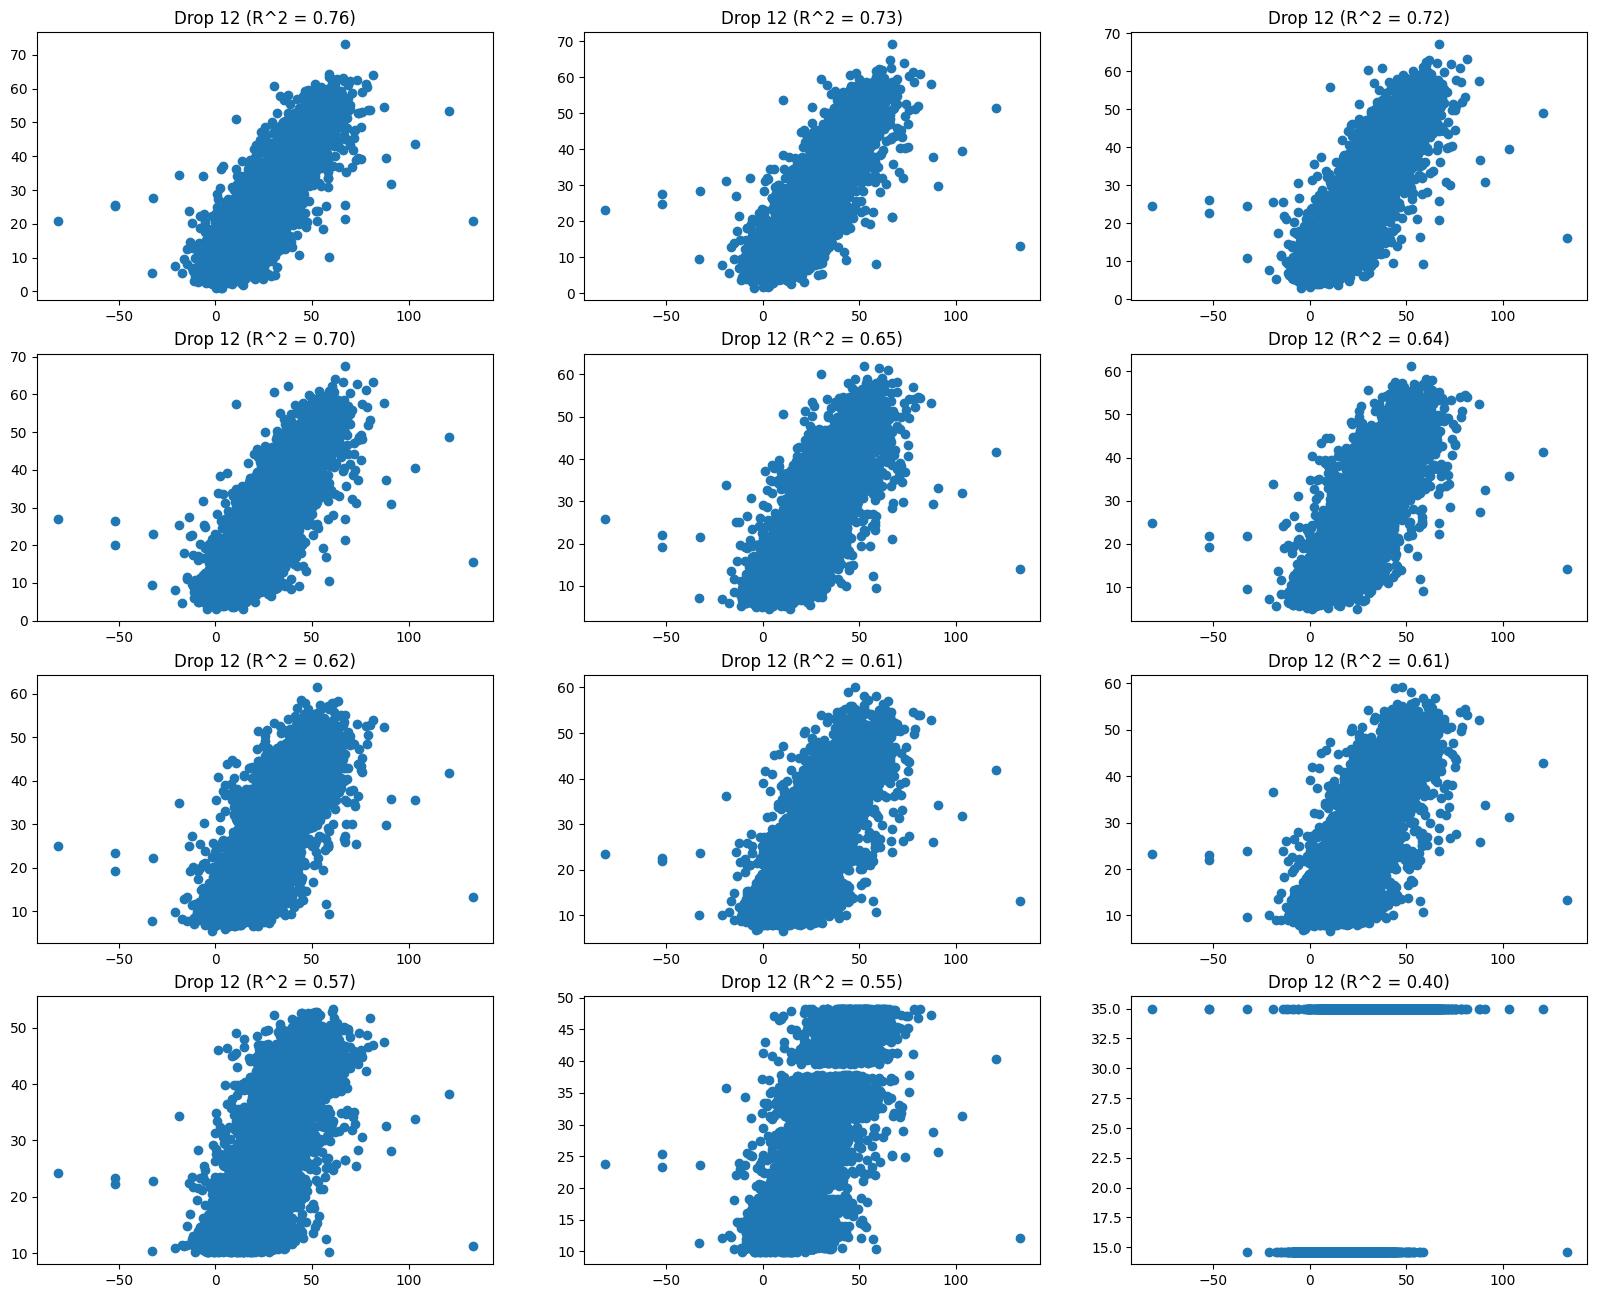

In [71]:
run_cate_masking_experiments(df, 
                             cov_results, 
                             treatment, 
                             y, 
                             train_idx, 
                             val_idx, 
                             extra_features=None,
                             true_cate=true_cate,
                             label_prefix="[CATE covs]",
                             max_steps=args.cate_max_steps)

## Experiment 3: Use DINO-V3 features to try to predict
Targets:
- outcome (direct prediction)
- treatment (perpensity)
- covariates (proxy)
- outcome + treatment (ignorability)

#### Exp 3.0: Linear Regression to directly predict

In [10]:

print("\n[Features -> Covariates]")
for cov in covariates + ["outcome", "treatment"]:
    res = features_to_targets(features, df[cov], train_idx, val_idx, f"features -> {cov}")
    print(f"{cov:<12} MAE={res.mae:.4f} | R^2={res.r2:.4f}")



[Features -> Covariates]
EP_NOINT     MAE=0.8881 | R^2=-0.2993
EP_DISABL    MAE=0.9189 | R^2=-0.3013
EP_AGE65     MAE=0.8368 | R^2=-0.3164
EP_NOVEH     MAE=0.8580 | R^2=-0.2501
EP_LIMENG    MAE=0.8620 | R^2=-0.2321
EP_AGE17     MAE=0.8886 | R^2=-0.3261
EP_UNEMP     MAE=0.8304 | R^2=-0.2414
RPL_THEME3   MAE=0.9464 | R^2=-0.2211
EP_SNGPNT    MAE=0.8851 | R^2=-0.2815
EP_MUNIT     MAE=0.8392 | R^2=-0.2651
EP_MINRTY    MAE=0.9487 | R^2=-0.2253
outcome      MAE=14.8659 | R^2=-0.2385
treatment    MAE=0.4968 | R^2=-0.1960


We can see that all predictions fail with negative R^2, which means:

The linear prediction using the features is worse than random guess -> there is no linear relationship 

#### Exp 3.1: predict everything with feature
this is very important:
- ignorability should hold if we want to use CausalPFN
- that means:
    - Y - outcome
    - X - covariates (partially masked)
    - Z - features
    - T - treatment
    - ignorability: Y(0), Y(1) independent to T | Z, X
- if we want to replace X with Z: we can try
    - Z -> Y, T
    - Z -> X

In [12]:
args.embedding_lr = 0.00001
for cov in covariates + ["outcome", "treatment"]:
    if cov == "treatment":
        cls = True
    else:
        cls = False
        
    embeddings, embed_val_mae, embed_val_r2 = train_linear_embedding(
        features,
        df[cov].to_numpy(),
        train_idx,
        val_idx,
        embedding_dim=args.embedding_dim,
        epochs=args.embedding_epochs,
        lr=args.embedding_lr,
        random_state=args.random_state,
        cls=cls,
        curve_label="curve_large_{}".format(cov),
    )
    print("Target:", cov, "mae:", embed_val_mae, "r2", embed_val_r2)

Saved training curve plot to /Users/bob/Downloads/baidu_cloud/留学-UofT/Courses/csc2541 - causality/project-spaCE/Spatial-Decision-Making-with-Amortized-Causal-Methods/space_dataset/downloads/training_curves/curve_large_EP_NOINT_curve.png
Target: EP_NOINT mae: 0.8356167078018188 r2 -0.16415119171142578
Saved training curve plot to /Users/bob/Downloads/baidu_cloud/留学-UofT/Courses/csc2541 - causality/project-spaCE/Spatial-Decision-Making-with-Amortized-Causal-Methods/space_dataset/downloads/training_curves/curve_large_EP_DISABL_curve.png
Target: EP_DISABL mae: 0.8593448996543884 r2 -0.1442934274673462
Saved training curve plot to /Users/bob/Downloads/baidu_cloud/留学-UofT/Courses/csc2541 - causality/project-spaCE/Spatial-Decision-Making-with-Amortized-Causal-Methods/space_dataset/downloads/training_curves/curve_large_EP_AGE65_curve.png
Target: EP_AGE65 mae: 0.7852393984794617 r2 -0.16855239868164062
Saved training curve plot to /Users/bob/Downloads/baidu_cloud/留学-UofT/Courses/csc2541 - causa

### Exp 3.2: features -> CausalPFN

[CATE covs] baseline           -> MAE=5.6407 | R^2=0.7587 | CATE mean=6.2100 std=3.8628 | PEHE=2.6349
[CATE covs] drop EP_NOINT (no internet) -> MAE=6.0048 | R^2=0.7324 | CATE mean=8.3600 std=4.1636 | PEHE=3.3824
[CATE covs] drop EP_DISABL (disabled residents) -> MAE=6.2722 | R^2=0.7158 | CATE mean=9.6726 std=3.8619 | PEHE=4.1863
[CATE covs] drop EP_AGE65 (age 65+) -> MAE=6.4787 | R^2=0.6998 | CATE mean=10.1620 std=3.7701 | PEHE=4.7115
[CATE covs] drop EP_NOVEH (no vehicle) -> MAE=7.1307 | R^2=0.6468 | CATE mean=13.4761 std=4.6603 | PEHE=7.8109
[CATE covs] drop EP_LIMENG (limited English proficiency) -> MAE=7.2669 | R^2=0.6355 | CATE mean=13.5535 std=4.5198 | PEHE=7.8094
[CATE covs] drop EP_AGE17 (age 17 or younger) -> MAE=7.3949 | R^2=0.6238 | CATE mean=13.4383 std=4.1488 | PEHE=7.6591
[CATE covs] drop EP_UNEMP (unemployment) -> MAE=7.5707 | R^2=0.6072 | CATE mean=13.9776 std=3.9089 | PEHE=8.0864
[CATE covs] drop RPL_THEME3 (SVI Theme 3 percentile) -> MAE=7.5768 | R^2=0.6066 | CATE mean=14.0215 std=4.0798 | PEHE=8.1373
[CATE covs] drop EP_SNGPNT (single-parent households) -> MAE=7.9472 | R^2=0.5733 | CATE mean=14.3504 std=3.7631 | PEHE=8.3649
[CATE covs] drop EP_MUNIT (multi-unit housing) -> MAE=8.1998 | R^2=0.5462 | CATE mean=14.0057 std=3.5150 | PEHE=7.9661
[CATE covs] drop EP_MINRTY (minority (non-white)) -> MAE=9.7257 | R^2=0.3955 | CATE mean=20.4062 std=0.0000 | PEHE=14.2312

[CATE covs] baseline           -> MAE=3.9501 | R^2=0.8629 | CATE mean=7.5532 std=5.3177 | PEHE=4.3409
[CATE covs] drop EP_NOINT (no internet) -> MAE=3.7476 | R^2=0.8707 | CATE mean=9.5559 std=4.8501 | PEHE=4.8385
[CATE covs] drop EP_DISABL (disabled residents) -> MAE=3.6350 | R^2=0.8813 | CATE mean=11.2671 std=5.3439 | PEHE=6.4583
[CATE covs] drop EP_AGE65 (age 65+) -> MAE=4.3940 | R^2=0.8400 | CATE mean=12.0701 std=5.5987 | PEHE=7.1527
[CATE covs] drop EP_NOVEH (no vehicle) -> MAE=5.6502 | R^2=0.7639 | CATE mean=13.7705 std=5.6397 | PEHE=8.6066
[CATE covs] drop EP_LIMENG (limited English proficiency) -> MAE=5.8807 | R^2=0.7513 | CATE mean=14.2089 std=5.8527 | PEHE=9.1560
[CATE covs] drop EP_AGE17 (age 17 or younger) -> MAE=5.9994 | R^2=0.7446 | CATE mean=13.9108 std=6.0317 | PEHE=9.0455
[CATE covs] drop EP_UNEMP (unemployment) -> MAE=6.4962 | R^2=0.7060 | CATE mean=14.2022 std=5.8940 | PEHE=9.2784
[CATE covs] drop RPL_THEME3 (SVI Theme 3 percentile) -> MAE=6.5863 | R^2=0.7010 | CATE m

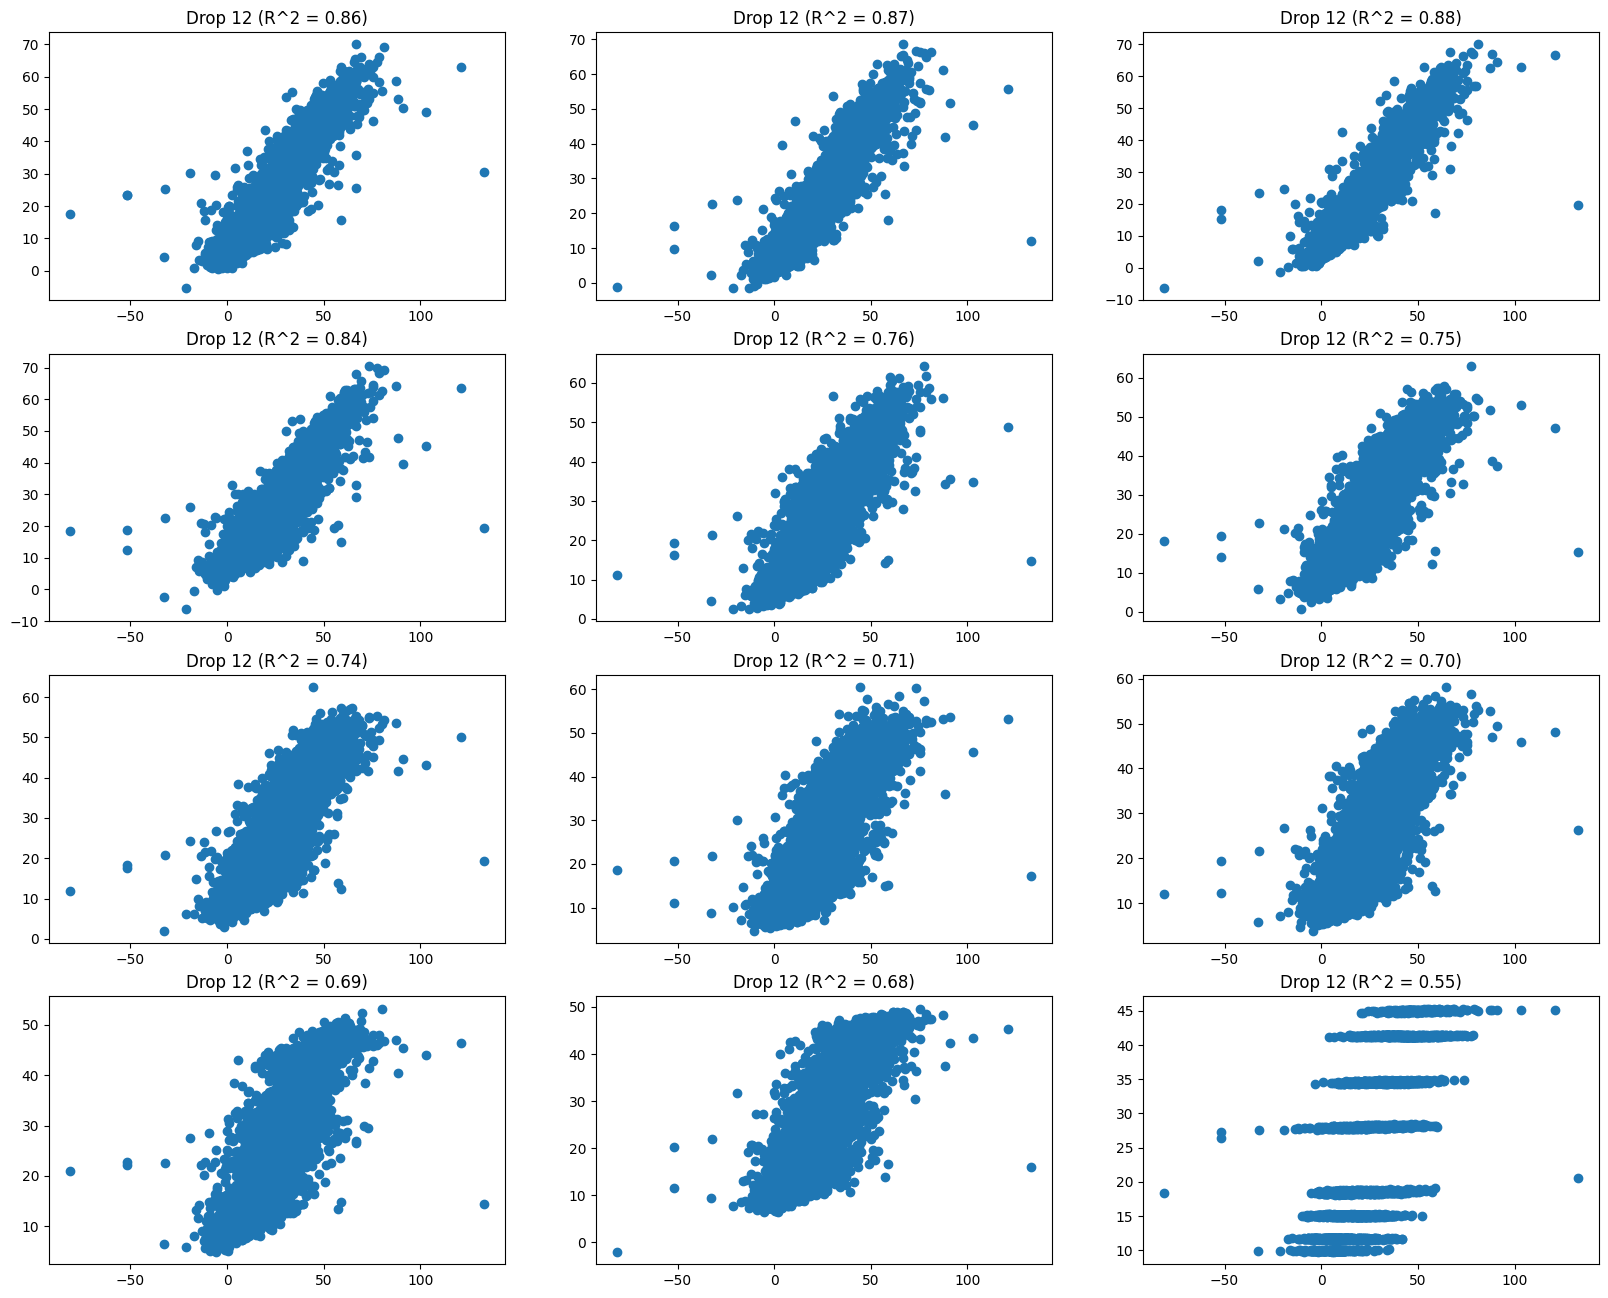

In [73]:
run_cate_masking_experiments(df, 
                             cov_results, 
                             treatment, 
                             y, 
                             train_idx, 
                             val_idx, 
                             extra_features=features,
                             true_cate=true_cate,
                             label_prefix="[CATE covs]",
                             max_steps=args.cate_max_steps)

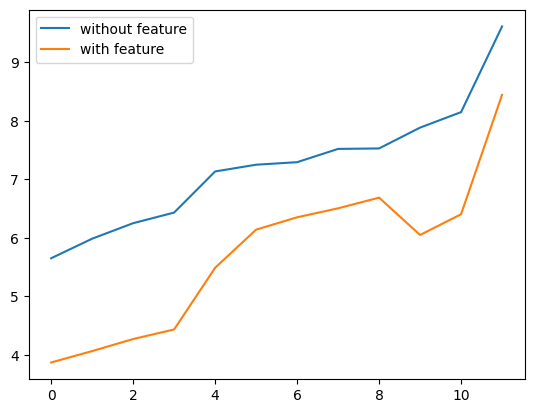

In [ ]:
a = [5.6498, 5.9840, 6.2489, 6.4304, 7.1328, 7.2482, 7.2913, 7.5181, 7.5260, 7.8818, 8.1466, 9.6098]
b = [3.8693, 4.0641, 4.2699, 4.4332, 5.4871, 6.1387, 6.3498, 6.5031, 6.6853, 6.0476, 6.4015, 8.4420]
plt.plot(a, label="without feature")
plt.plot(b, label="with feature")
plt.legend()

So, the result shows that the model is actually overfitting...

## Experiment 4: use graph as proxy to smooth the distribution
by using metric learning

see `metric_learning.py` -> downloads/metric_embeddings.pt

In [60]:
ml_embeddings = torch.load("downloads/metric_embeddings-32.pt")['embeddings'].numpy()

In [13]:
args.embedding_lr = 0.00001
for cov in covariates + ["outcome", "treatment"]:
    if cov == "treatment":
        cls = True
    else:
        cls = False
        
    embeddings, embed_val_mae, embed_val_r2 = train_linear_embedding(
        ml_embeddings,
        df[cov].to_numpy(),
        train_idx,
        val_idx,
        embedding_dim=args.embedding_dim,
        epochs=args.embedding_epochs,
        lr=args.embedding_lr,
        random_state=args.random_state,
        cls=cls,
        curve_label="curve_ml_{}".format(cov),
    )
    print("Target:", cov, "mae:", embed_val_mae, "r2", embed_val_r2)

AssertionError: batch size should be times to class

In [61]:
from scipy.spatial.distance import cdist
dists = cdist(ml_embeddings, ml_embeddings, 'cosine')

## Experiment 5: use embeddings to test out CausalPFN

Train: MAE=5.3690 | R^2=0.7734 | CATE=7.0159[CATE cov+feat] baseline           -> MAE=6.1862 | R^2=0.7180 | CATE mean=7.2673 std=3.7845 | PEHE=2.7122
Train: MAE=5.8505 | R^2=0.7417 | CATE=8.9986[CATE cov+feat] drop EP_NOINT (no internet) -> MAE=6.6614 | R^2=0.6824 | CATE mean=9.5282 std=3.6959 | PEHE=3.9660
Train: MAE=5.9801 | R^2=0.7350 | CATE=10.6199[CATE cov+feat] drop EP_DISABL (disabled residents) -> MAE=6.8614 | R^2=0.6707 | CATE mean=11.0576 std=3.6003 | PEHE=5.3146
Train: MAE=6.1810 | R^2=0.7185 | CATE=10.6523[CATE cov+feat] drop EP_AGE65 (age 65+) -> MAE=6.9079 | R^2=0.6671 | CATE mean=10.9591 std=3.7380 | PEHE=5.3607
Train: MAE=6.8812 | R^2=0.6667 | CATE=13.5446[CATE cov+feat] drop EP_NOVEH (no vehicle) -> MAE=7.9467 | R^2=0.5810 | CATE mean=14.1558 std=3.9082 | PEHE=8.2446
Train: MAE=7.0291 | R^2=0.6497 | CATE=13.9212[CATE cov+feat] drop EP_LIMENG (limited English proficiency) -> MAE=8.0456 | R^2=0.5681 | CATE mean=14.6887 std=3.9550 | PEHE=8.7870
Train: MAE=7.1164 | R^2=0.6

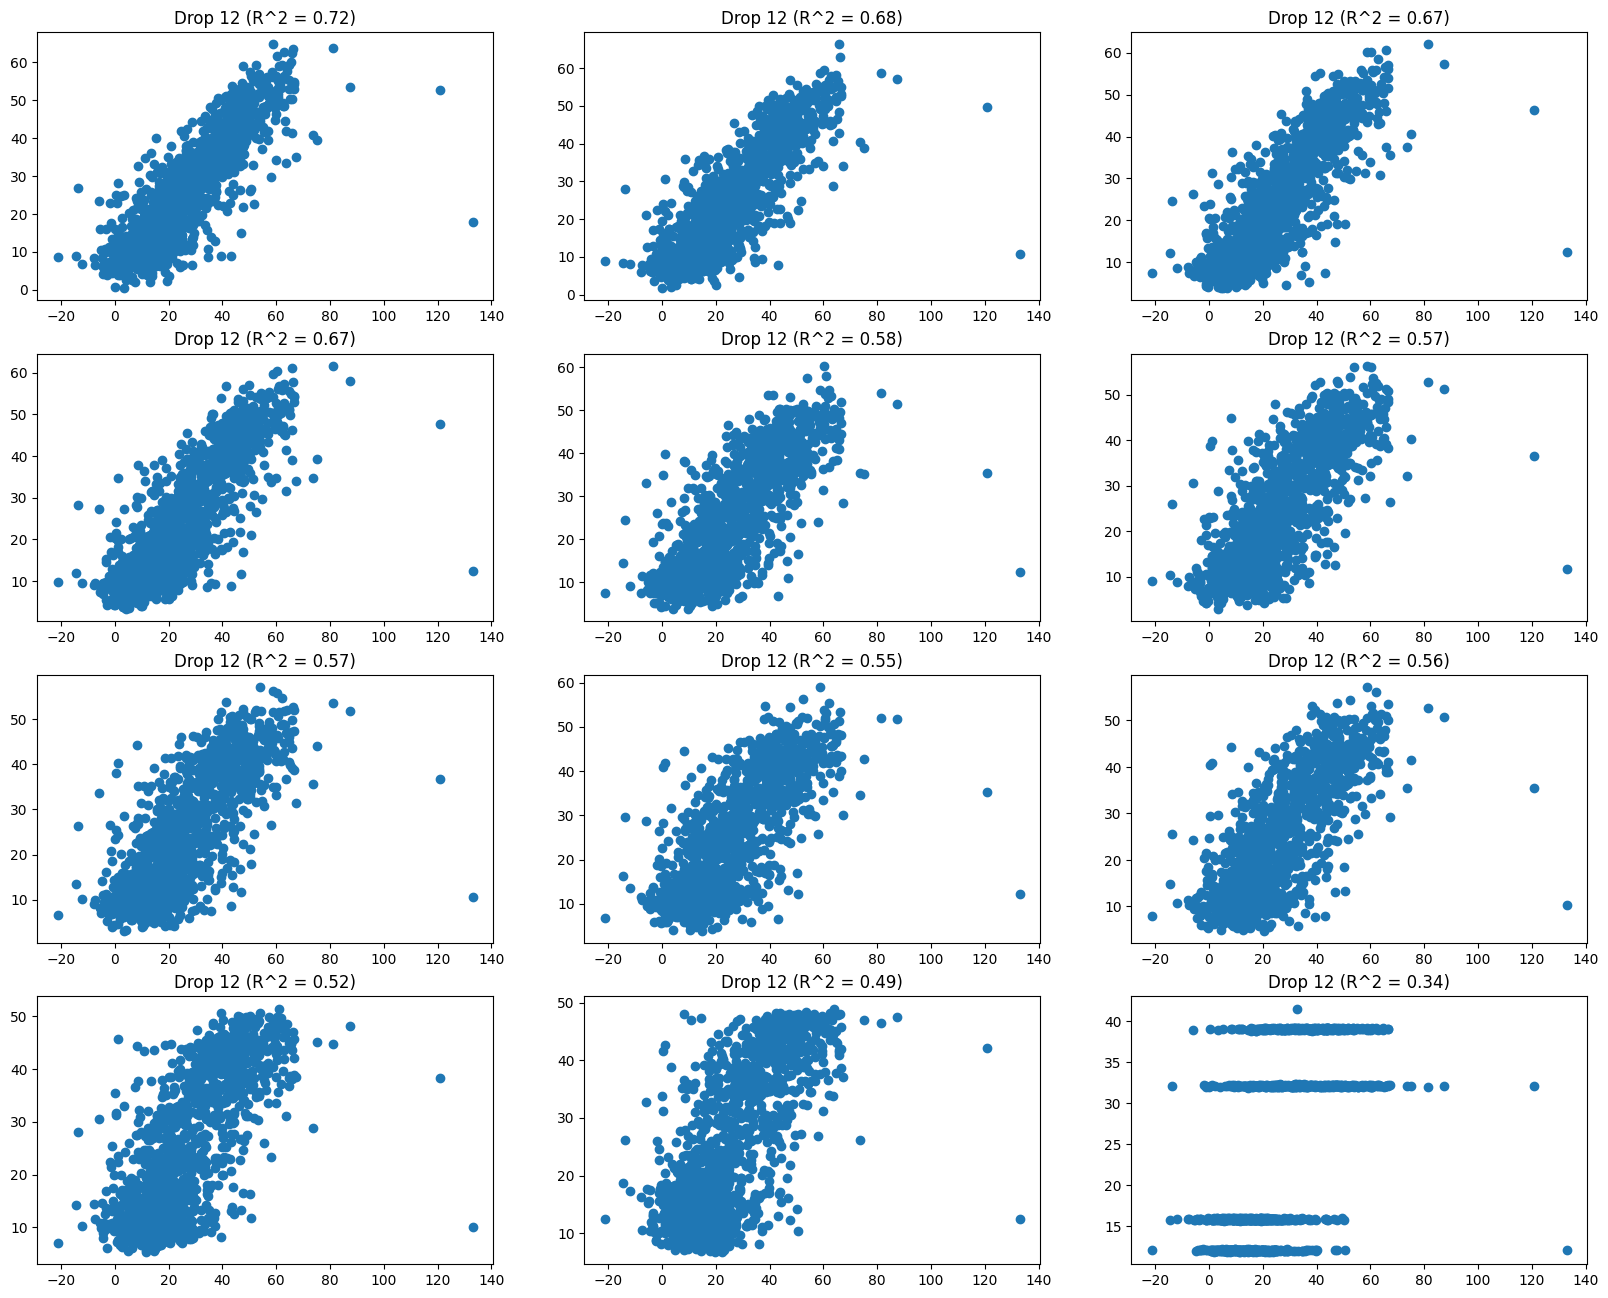

In [61]:
run_cate_masking_experiments(
    df,
    cov_results,
    treatment,
    y,
    train_idx,
    val_idx,
    extra_features=ml_embeddings,
    true_cate=true_cate,
    label_prefix="[CATE cov+feat]",
    max_steps=args.cate_max_steps,
)

## Experiment 5.1: ml embeddings -> train on outcome & treatment -> causalPFN

In [25]:
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler


class MultiTaskLinearEmbeddingModel(torch.nn.Module):
    def __init__(
        self,
        input_dim: int,
        embedding_dim: int,
        regression_targets: int,
        classification_targets: int = 1,
    ) -> None:
        super().__init__()
        self.embedding = nn.Sequential(
            torch.nn.Linear(input_dim, input_dim * 2),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(input_dim * 2, input_dim),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(input_dim, embedding_dim),
        )
        self.bnneck = nn.BatchNorm1d(embedding_dim)
        self.regression_head = torch.nn.Linear(embedding_dim, regression_targets)
        self.classification_head = torch.nn.Linear(embedding_dim, classification_targets)

    def forward(
        self, x: torch.Tensor
    ) -> tuple[torch.Tensor, torch.Tensor | None, torch.Tensor]:
        z = self.embedding(x)
        neck = self.bnneck(z)
        reg_out = self.regression_head(neck)
        cls_out = self.classification_head(neck)
        return reg_out, cls_out, z

def train_multitask_embedding(
    features: np.ndarray,
    covariate_targets: np.ndarray,
    outcome: np.ndarray,
    treatment: np.ndarray,
    train_idx: np.ndarray,
    val_idx: np.ndarray,
    embedding_dim: int,
    epochs: int,
    lr: float,
    random_state: int,
    curve_label: str | None = None,
) -> tuple[np.ndarray, float, float, float]:
    """Jointly train embeddings to predict covariates/outcome and classify treatment."""
    # standardize regression as well
    y = outcome[train_idx]
    y_mean = y.mean()
    y_std = y.std() + 1e-6
    outcome = (outcome - y_mean) / y_std

    regression_targets = outcome.reshape(-1, 1)
    regression_targets = np.concat((regression_targets, covariate_targets), axis=1)
    print(regression_targets.shape)
    classification_targets = treatment.reshape(-1, 1)

    torch.manual_seed(random_state)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = MultiTaskLinearEmbeddingModel(
        input_dim=features.shape[1],
        embedding_dim=embedding_dim,
        regression_targets=regression_targets.shape[1],
        classification_targets=classification_targets.shape[1],
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    mse_loss = torch.nn.MSELoss()
    bce_loss = torch.nn.BCEWithLogitsLoss()

    X_train = torch.from_numpy(features[train_idx]).float().to(device)
    y_reg_train = torch.from_numpy(regression_targets[train_idx]).float().to(device)
    y_cls_train = torch.from_numpy(classification_targets[train_idx]).float().to(device)

    X_val = torch.from_numpy(features[val_idx]).float().to(device)
    y_reg_val = torch.from_numpy(regression_targets[val_idx]).float().to(device)
    y_cls_val = torch.from_numpy(classification_targets[val_idx]).float().to(device)

    batch_size = 128
    train_loss_history: List[float] = []
    val_metric_history: List[float] = []
    val_loss_history_reg = []
    val_loss_history_cls = []

    labels = y_cls_train.view(-1).long()  # shape [N], ints
    class_counts = torch.bincount(labels)
    class_weights = 1.0 / class_counts.float()
    sample_weights = class_weights[labels]   # weight per sample
    print(class_weights)

    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )

    train_ds = TensorDataset(X_train, y_reg_train, y_cls_train)
    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        sampler=sampler,
        drop_last=True
    )

    for ep in range(epochs):
        model.train()
        losses = []
        for X_b, y_reg_b, y_cls_b in train_loader:
            optimizer.zero_grad()
            reg_preds, cls_preds, _ = model(X_b)
            mse = mse_loss(reg_preds, y_reg_b)
            bce = bce_loss(cls_preds, y_cls_b)
            loss = mse + bce
            # loss = bce
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            losses.append(loss.item())
        train_loss_history.append(float(np.mean(losses) if losses else 0.0))

        with torch.no_grad():
            reg_val_pred, cls_val_pred, _ = model(X_val)
            val_reg_loss = mse_loss(reg_val_pred, y_reg_val)
            val_cls_loss = (
                bce_loss(cls_val_pred, y_cls_val) if cls_val_pred is not None else 0.0
            )
            val_metric_history.append(float((val_reg_loss + val_cls_loss).item()))
            val_loss_history_cls.append(val_cls_loss.item())
            val_loss_history_reg.append(val_reg_loss.item())

    label = curve_label or "joint_embedding"
    plot_path = plot_training_curves(train_loss_history, val_metric_history, label)
    _ = plot_training_curves(val_loss_history_reg, val_loss_history_cls, "reg_cls_losses_val")
    print(f"Saved training curve plot to {plot_path}")

    with torch.no_grad():
        reg_val_pred, cls_val_pred, _ = model(X_val)
        cov_preds = reg_val_pred[:, :-1]
        outcome_preds = reg_val_pred[:, -1]
        treatment_probs = (
            torch.sigmoid(cls_val_pred).cpu().numpy()
            if cls_val_pred is not None
            else None
        )

        # cov_mae = mean_absolute_error(
        #     y_reg_val[:, :-1].cpu().numpy(),
        #     cov_preds.cpu().numpy(),
        # )
        cov_mae = 0
        outcome_mae = mean_absolute_error(
            y_reg_val[:, -1].cpu().numpy(),
            outcome_preds.cpu().numpy(),
        )
        treatment_acc = (
            accuracy_score(
                y_cls_val.cpu().numpy().ravel().astype(int),
                (treatment_probs >= 0.5).astype(int).ravel(),
            )
            if treatment_probs is not None
            else float("nan")
        )

        all_embeddings = (
            model.embedding(torch.from_numpy(features).float().to(device)).cpu().numpy()
        )

    return all_embeddings, cov_mae, outcome_mae, treatment_acc


In [26]:

new_embeddings, cov_mae, outcome_mae, treatment_acc = train_multitask_embedding(
    ml_embeddings,
    df[covariates].to_numpy(),
    y,
    treatment,
    train_idx,
    val_idx,
    embedding_dim=args.embedding_dim,
    epochs=200,
    lr=0.00001,
    random_state=args.random_state,
    curve_label="ml_joint_multitask",
)

(6693, 12)
tensor([0.0004, 0.0004])
Saved training curve plot to /Users/bob/Downloads/baidu_cloud/留学-UofT/Courses/csc2541 - causality/project-spaCE/Spatial-Decision-Making-with-Amortized-Causal-Methods/space_dataset/downloads/training_curves/ml_joint_multitask_curve.png


In [27]:

print("\n[New embeddings -> Covariates]")
for cov in covariates + ["outcome", "treatment"]:
    res = features_to_targets(new_embeddings, df[cov], train_idx, val_idx, f"new embeddings -> {cov}")
    print(f"{cov:<12} MAE={res.mae:.4f} | R^2={res.r2:.4f}")



[New embeddings -> Covariates]
EP_NOINT     MAE=0.7869 | R^2=-0.0013
EP_DISABL    MAE=0.8109 | R^2=-0.0061
EP_AGE65     MAE=0.7350 | R^2=-0.0132
EP_NOVEH     MAE=0.7525 | R^2=-0.0013
EP_LIMENG    MAE=0.7659 | R^2=0.0015
EP_AGE17     MAE=0.7722 | R^2=-0.0147
EP_UNEMP     MAE=0.7448 | R^2=-0.0129
RPL_THEME3   MAE=0.8893 | R^2=-0.0026
EP_SNGPNT    MAE=0.7809 | R^2=-0.0036
EP_MUNIT     MAE=0.7490 | R^2=-0.0025
EP_MINRTY    MAE=0.8932 | R^2=-0.0040
outcome      MAE=13.6108 | R^2=-0.0049
treatment    MAE=0.4982 | R^2=0.0027


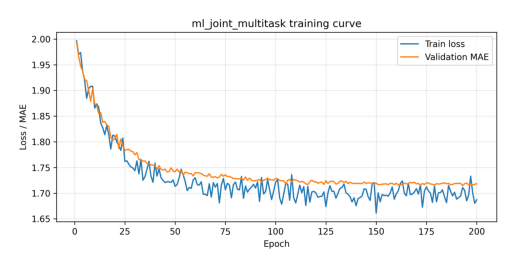

In [28]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Specify the path to your image file
image_path = './downloads/training_curves/ml_joint_multitask_curve.png'  # Replace with the actual path to your image

# Read the image using imread()
image_data = mpimg.imread(image_path)

# Display the image (optional)
plt.imshow(image_data)
plt.axis('off')  # Turn off axis labels and ticks for cleaner image display
plt.show()

In [29]:
run_cate_masking_experiments(
    df,
    cov_results,
    treatment,
    y,
    train_idx,
    val_idx,
    extra_features=new_embeddings,
    true_cate=true_cate,
    label_prefix="[CATE cov+feat]",
    max_steps=args.cate_max_steps,
)

[CATE cov+feat] baseline           -> MAE=6.2179 | R^2=0.7161 | CATE mean=6.6029 std=3.8402 | PEHE=2.7001
[CATE cov+feat] drop EP_NOINT (no internet) -> MAE=6.6903 | R^2=0.6806 | CATE mean=9.1692 std=3.8985 | PEHE=3.7613
[CATE cov+feat] drop EP_DISABL (disabled residents) -> MAE=6.9139 | R^2=0.6692 | CATE mean=10.5212 std=3.6003 | PEHE=4.7858
[CATE cov+feat] drop EP_AGE65 (age 65+) -> MAE=6.9552 | R^2=0.6637 | CATE mean=10.5598 std=3.5004 | PEHE=4.9909
[CATE cov+feat] drop EP_NOVEH (no vehicle) -> MAE=7.7938 | R^2=0.5939 | CATE mean=13.8988 std=3.8857 | PEHE=7.8851
[CATE cov+feat] drop EP_LIMENG (limited English proficiency) -> MAE=7.9205 | R^2=0.5844 | CATE mean=14.3798 std=4.2347 | PEHE=8.4181
[CATE cov+feat] drop EP_AGE17 (age 17 or younger) -> MAE=7.8995 | R^2=0.5848 | CATE mean=14.2262 std=3.9259 | PEHE=8.2290
[CATE cov+feat] drop EP_UNEMP (unemployment) -> MAE=8.0729 | R^2=0.5672 | CATE mean=14.8015 std=3.9237 | PEHE=8.8336
[CATE cov+feat] drop RPL_THEME3 (SVI Theme 3 percentile)

## Experiment 6: use coordinates instead of feature
because the coordinates are what the data was generated with

In [19]:
coordinates = np.load("data/cdcsvi_nohsdp_poverty_disc/coordinates.npy")

In [20]:
coordinates.shape

(6693, 2)

In [23]:
mean = coordinates.mean(axis=0)
std = coordinates.std(axis=0)
coordinates = (coordinates - mean) / std
run_cate_masking_experiments(
    df,
    cov_results,
    treatment,
    y,
    train_idx,
    val_idx,
    extra_features=coordinates,
    true_cate=true_cate,
    label_prefix="[CATE cov+coordinates]",
    max_steps=args.cate_max_steps,
)

[CATE cov+coordinates] baseline           -> MAE=6.1299 | R^2=0.7205 | CATE mean=6.4615 std=3.7849 | PEHE=2.7369
[CATE cov+coordinates] drop EP_NOINT (no internet) -> MAE=6.6186 | R^2=0.6892 | CATE mean=8.8621 std=3.7801 | PEHE=3.5116
[CATE cov+coordinates] drop EP_DISABL (disabled residents) -> MAE=6.8366 | R^2=0.6776 | CATE mean=9.9092 std=3.4938 | PEHE=4.1963
[CATE cov+coordinates] drop EP_AGE65 (age 65+) -> MAE=6.9202 | R^2=0.6676 | CATE mean=10.4129 std=3.4436 | PEHE=4.8280
[CATE cov+coordinates] drop EP_NOVEH (no vehicle) -> MAE=7.6882 | R^2=0.6017 | CATE mean=13.7401 std=3.8633 | PEHE=7.7049
[CATE cov+coordinates] drop EP_LIMENG (limited English proficiency) -> MAE=7.8025 | R^2=0.5937 | CATE mean=14.0286 std=3.9905 | PEHE=8.0091
[CATE cov+coordinates] drop EP_AGE17 (age 17 or younger) -> MAE=7.8979 | R^2=0.5848 | CATE mean=13.9899 std=3.7596 | PEHE=7.9893
[CATE cov+coordinates] drop EP_UNEMP (unemployment) -> MAE=8.0116 | R^2=0.5705 | CATE mean=14.3990 std=3.4712 | PEHE=8.2947
[

In [22]:
run_cate_masking_experiments(
    df,
    cov_results,
    treatment,
    y,
    train_idx,
    val_idx,
    extra_features=None,
    true_cate=true_cate,
    label_prefix="[CATE cov]",
    max_steps=args.cate_max_steps,
)

[CATE cov+coordinates] baseline           -> MAE=6.1009 | R^2=0.7224 | CATE mean=6.3929 std=3.7370 | PEHE=2.6879
[CATE cov+coordinates] drop EP_NOINT (no internet) -> MAE=6.5702 | R^2=0.6925 | CATE mean=8.6462 std=3.7172 | PEHE=3.2141
[CATE cov+coordinates] drop EP_DISABL (disabled residents) -> MAE=6.8193 | R^2=0.6786 | CATE mean=9.8729 std=3.3938 | PEHE=4.0859
[CATE cov+coordinates] drop EP_AGE65 (age 65+) -> MAE=6.9284 | R^2=0.6685 | CATE mean=10.4777 std=3.4212 | PEHE=4.7940
[CATE cov+coordinates] drop EP_NOVEH (no vehicle) -> MAE=7.7096 | R^2=0.6017 | CATE mean=13.6783 std=3.8000 | PEHE=7.6289
[CATE cov+coordinates] drop EP_LIMENG (limited English proficiency) -> MAE=7.8458 | R^2=0.5904 | CATE mean=13.9262 std=3.9842 | PEHE=7.8986
[CATE cov+coordinates] drop EP_AGE17 (age 17 or younger) -> MAE=7.8954 | R^2=0.5864 | CATE mean=13.7932 std=3.6261 | PEHE=7.7221
[CATE cov+coordinates] drop EP_UNEMP (unemployment) -> MAE=7.9956 | R^2=0.5746 | CATE mean=14.3565 std=3.3421 | PEHE=8.2172
[

## Experiment 7: standardize outcome

Result: it does not matter

[24.82436387] [16.0612806]
[CATE cov] baseline           -> MAE=0.3871 | R^2=0.7161 | CATE mean=6.5999 std=3.8365 | PEHE=2.6978
[CATE cov] drop EP_NOINT (no internet) -> MAE=0.4166 | R^2=0.6806 | CATE mean=9.1692 std=3.8985 | PEHE=3.7613
[CATE cov] drop EP_DISABL (disabled residents) -> MAE=0.4307 | R^2=0.6690 | CATE mean=10.5266 std=3.5991 | PEHE=4.7903
[CATE cov] drop EP_AGE65 (age 65+) -> MAE=0.4330 | R^2=0.6637 | CATE mean=10.5593 std=3.5009 | PEHE=4.9906
[CATE cov] drop EP_NOVEH (no vehicle) -> MAE=0.4853 | R^2=0.5939 | CATE mean=13.8988 std=3.8857 | PEHE=7.8851
[CATE cov] drop EP_LIMENG (limited English proficiency) -> MAE=0.4931 | R^2=0.5844 | CATE mean=14.3798 std=4.2347 | PEHE=8.4182
[CATE cov] drop EP_AGE17 (age 17 or younger) -> MAE=0.4917 | R^2=0.5851 | CATE mean=14.2289 std=3.9284 | PEHE=8.2313
[CATE cov] drop EP_UNEMP (unemployment) -> MAE=0.5026 | R^2=0.5672 | CATE mean=14.8015 std=3.9237 | PEHE=8.8336
[CATE cov] drop RPL_THEME3 (SVI Theme 3 percentile) -> MAE=0.5028 | R

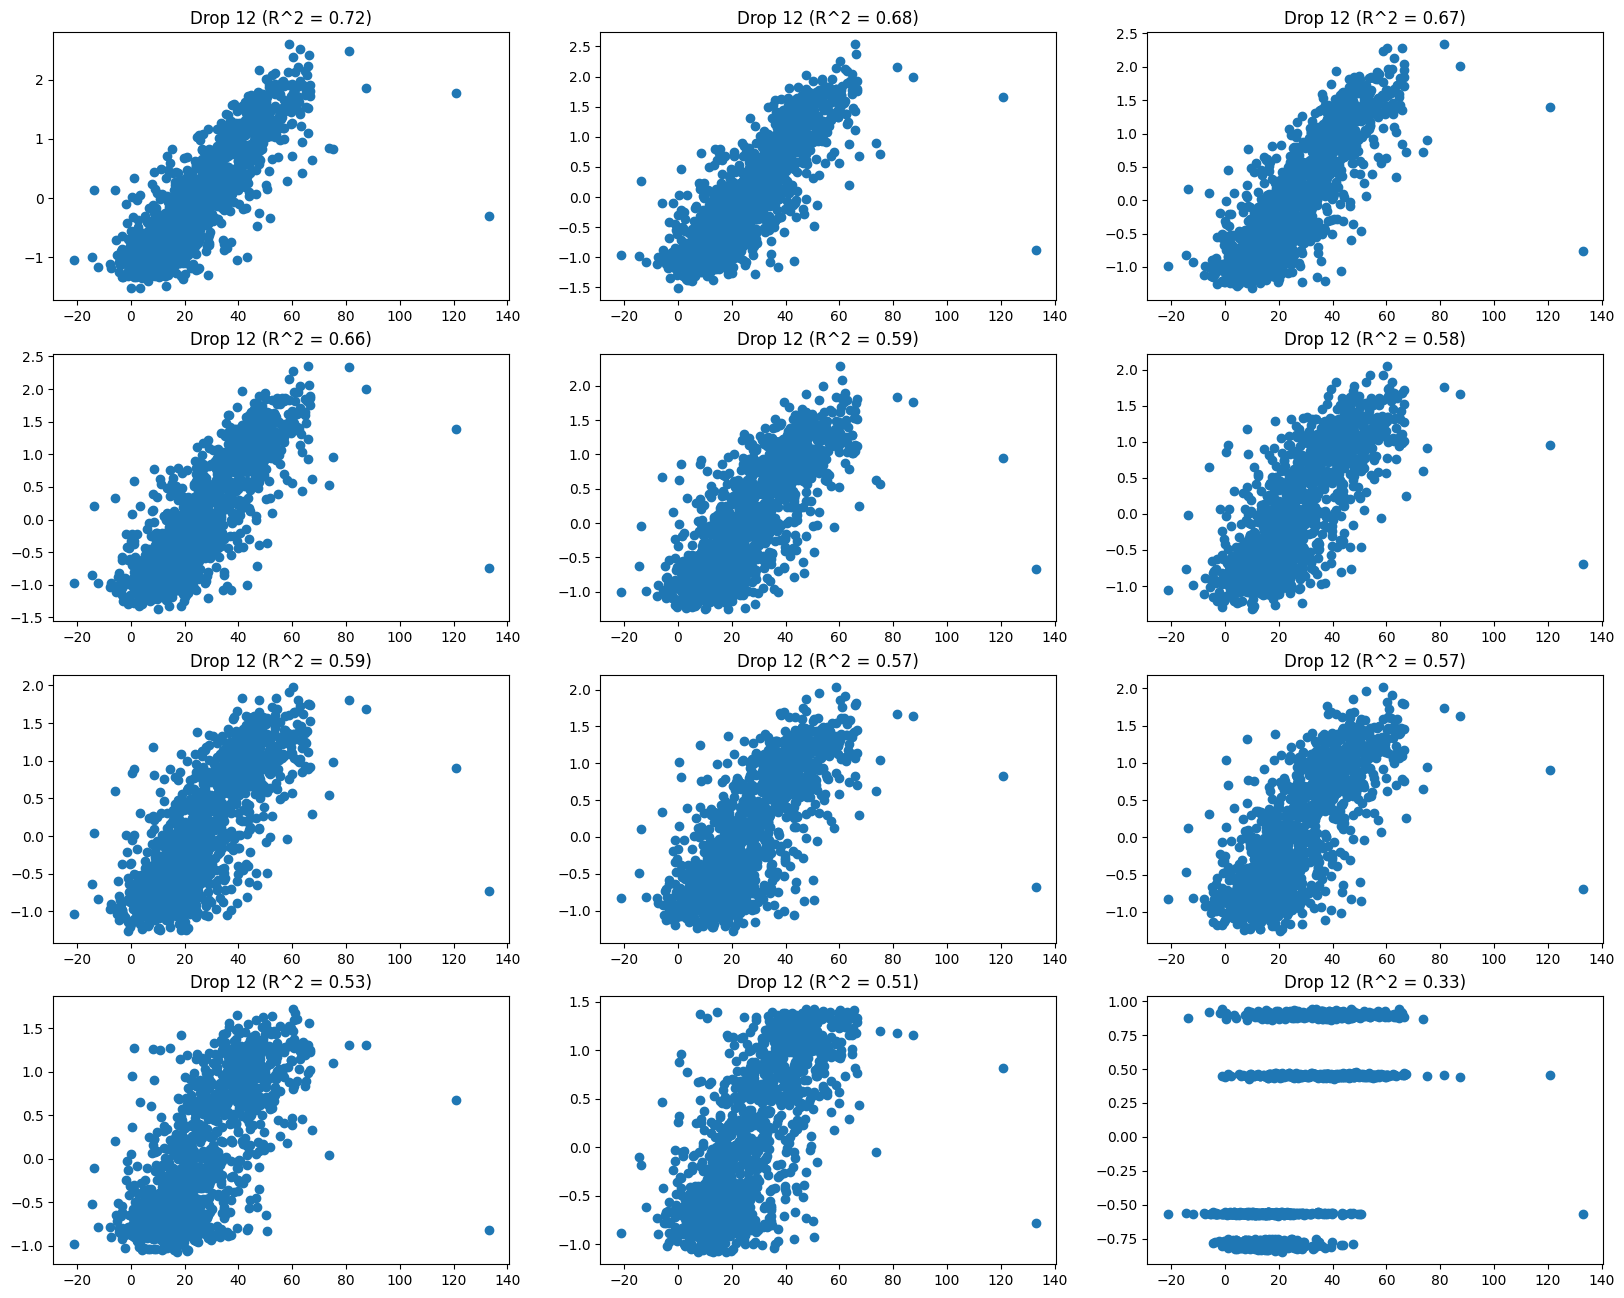

In [38]:

run_cate_masking_experiments(
    df,
    cov_results,
    treatment,
    y,
    train_idx,
    val_idx,
    extra_features=new_embeddings,
    true_cate=true_cate,
    label_prefix="[CATE cov]",
    max_steps=args.cate_max_steps,
    standardize=True
)

## Experiment 8: Train CEPO based on the data

In [ ]:
class CEPOTrainer(nn.Module):
    """
    Train embedding 
    """
    def __init__(self, feat_dim, embed_dim):
        self.cate_estimator = CATEEstimator()
        self.cate_estimator.load_model() # load model
        self.icl_model = self.cate_estimator.icl_model
        self.embedding = nn.Linear(feat_dim, embed_dim)

    def forward(self, features, covariates, treatment, outcome):
        embed = self.embedding(features)
        

    